# Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация
## Домашнее задание
Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
dataset = fetch_california_housing(as_frame=True)

In [3]:
dataset['data']

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


Посмотрим распределения фитчей:

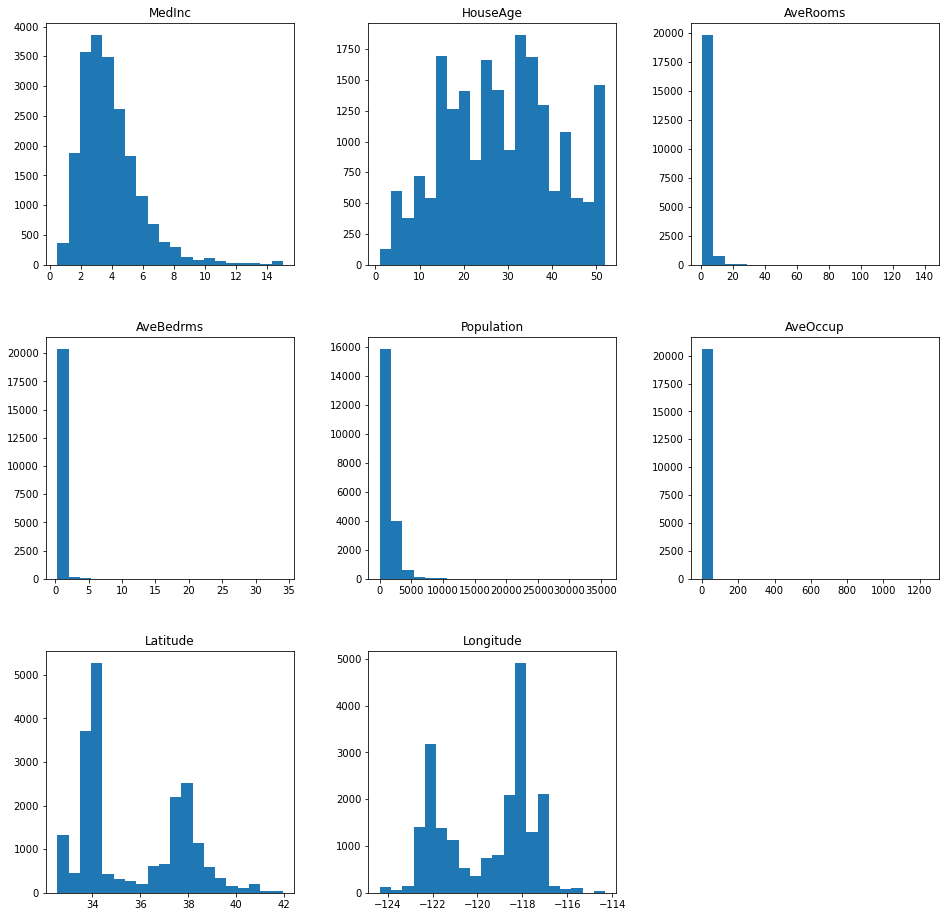

In [4]:
dataset['data'].hist(figsize=(16,16), bins=20, grid=False)
plt.show()

У 4-х фитчей распределение с очень длинным хвостом. Применим для них логарифмирование.

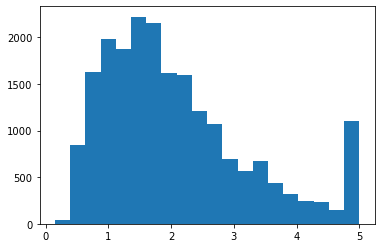

In [5]:
y = dataset['target']
y.hist(bins=20, grid=False)
plt.show()

In [6]:
dataset['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

C:\Users\amfet\AppData\Local\Temp/ipykernel_12088/1589579883.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = np.log(X[i] + 1)


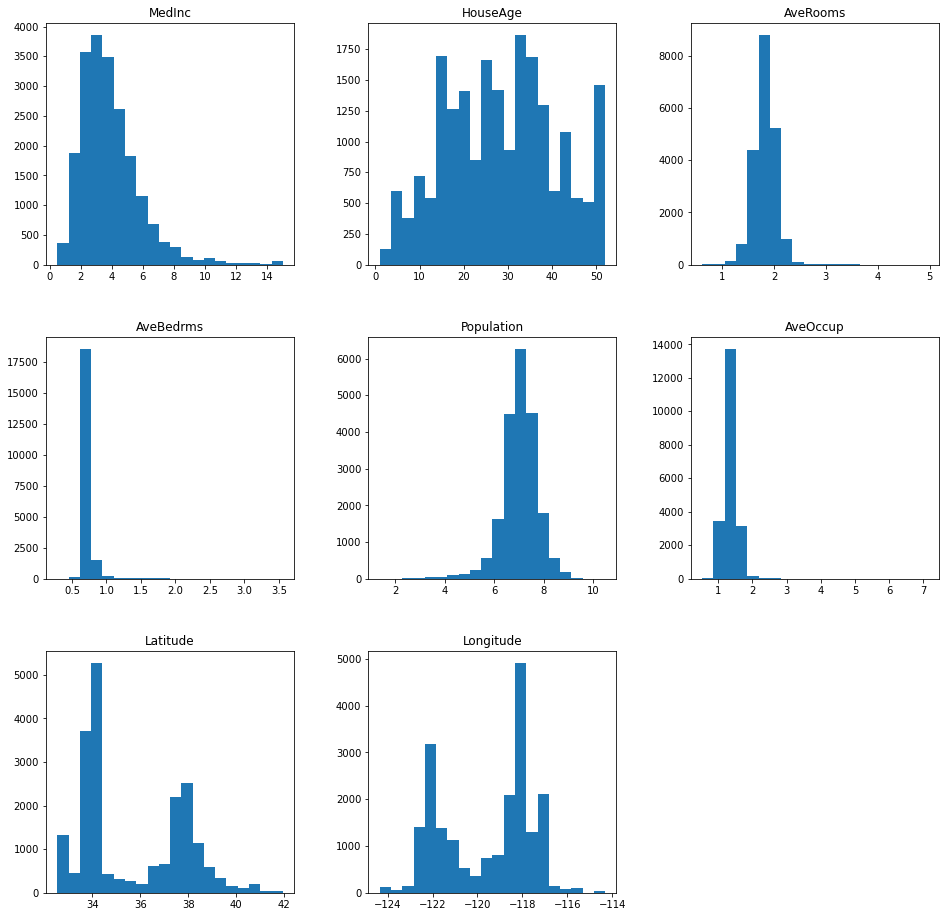

In [7]:
X = dataset['data']
prep_cols = ['AveRooms',
            'AveBedrms',
            'Population',
            'AveOccup']
for i in prep_cols:
  X[i] = np.log(X[i] + 1)
dataset['data'].hist(figsize=(16,16), bins=20, grid=False)
plt.show()

После логарифмирования распределение 4-х фичей стало намного лучше.
Разобьем выборку на тренировочную и тестовую, а потом проведем стандартизацию.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7
count,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04,1.548000e+04
mean,-1.134823e-16,3.256080e-18,-5.885688e-16,9.143517e-16,-3.515652e-16,-4.524948e-16,-1.781894e-15,3.619557e-16
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00
min,-1.770818e+00,-2.205284e+00,-4.639948e+00,-4.231102e+00,-7.171006e+00,-3.952088e+00,-1.449211e+00,-2.367473e+00
25%,-6.877530e-01,-8.528508e-01,-5.802782e-01,-3.383509e-01,-4.853545e-01,-5.700157e-01,-8.021129e-01,-1.109468e+00
50%,-1.783232e-01,2.225275e-02,3.406177e-03,-1.417095e-01,4.693957e-02,-5.484873e-02,-6.484853e-01,5.363810e-01
75%,4.626776e-01,6.586917e-01,5.393808e-01,9.266408e-02,5.851758e-01,4.890473e-01,9.669320e-01,7.849986e-01
max,5.866520e+00,1.852015e+00,1.356998e+01,2.691051e+01,4.722328e+00,2.764048e+01,2.931503e+00,2.624769e+00


In [11]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7
count,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000,5160.000000
mean,0.018345,-0.025711,0.012539,0.004871,-0.034147,-0.002135,-0.039326,0.037834
std,1.002460,1.004714,1.016673,1.015951,1.029463,0.973150,0.976677,0.984272
min,-1.770818,-2.205284,-5.260045,-3.468721,-7.725892,-3.791629,-1.439900,-2.327694
25%,-0.671557,-0.852851,-0.580771,-0.347076,-0.523808,-0.571618,-0.802113,-1.029910
50%,-0.150355,0.022253,0.010736,-0.135699,0.028712,-0.062725,-0.657796,0.556270
75%,0.467734,0.658692,0.560644,0.095535,0.557303,0.499915,0.939000,0.789971
max,5.866520,1.852015,9.179350,16.839997,3.635140,14.747873,2.889604,2.545211


На тесте среднее и дисперсия практически соответствуют нормальному распределению

In [12]:
class MyOwnCalifornia(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, init_target):
        self._base_dataset = init_dataset.astype('float32')
        self._base_target = np.array(init_target.astype('float32')).reshape(-1, 1)

    def __len__(self):
        return self._base_dataset.shape[0]

    def __getitem__(self, idx):
        feats, target = self._base_dataset[idx], self._base_target[idx]
        return feats, target

In [13]:
dataset = MyOwnCalifornia(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset,
                          batch_size=2048,
                          shuffle=True,
                          num_workers=0)

In [14]:
test_dataset = MyOwnCalifornia(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=512,
                          shuffle=False,
                          num_workers=0)

Соберем сеть. Так как данные стадартизированы, применим leaky_relu, а на выходном слое возьмем relu, так как у цены не может быть отрицательных значений.

In [15]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, bn_dp):
        super().__init__()
        self.bn_dp = bn_dp
        self.fc1 = Perceptron(input_dim, hidden_dim, activation="leaky_relu")
        if bn_dp:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.dp1 = nn.Dropout(0.2)
        self.fc2 = Perceptron(hidden_dim, int(hidden_dim / 2), activation="leaky_relu")
        if bn_dp == 2:
            self.bn2 = nn.BatchNorm1d(int(hidden_dim / 2))
            self.dp2 = nn.Dropout(0.2)
        self.fc3 = Perceptron(int(hidden_dim / 2), 1, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        if self.bn_dp:
            x = self.dp1(x)
            x = self.bn1(x)
        x = self.fc2(x)
        if self.bn_dp == 2:
            x = self.dp2(x)
            x = self.bn2(x)
        x = self.fc3(x)
        return x

In [16]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [17]:
num_epochs = 120
def learn_net(num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):  
        running_loss, r2 = 0.0, 0.0
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            r2 += r2_loss(outputs, target).item()
            

        net.eval()
        train_losses.append(running_loss / (i + 1))
        print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
              f'Loss: {running_loss / (i + 1):.3f}. ' \
              f'R2: {r2 / (i + 1):.3f}', end='. ')
        running_loss, r2 = 0.0, 0.0

        test_running_loss, test_r2 = 0.0, 0.0
        for j, data in enumerate(test_loader):
        
            test_outputs = net(data[0])
            test_running_loss += criterion(test_outputs, data[1]).item()
            test_r2 += r2_loss(outputs, target).item()
        test_losses.append(test_running_loss / (j + 1))
        print(f'Test Loss: {test_running_loss / (j + 1):.3f}. ' \
              f'Test R2: {test_r2 / (j + 1):.3f}')
        net.train()
            
    print('Training is finished!')
    return train_losses, test_losses

Проведем три эксперимента - в первом не будет связки слоев dropout+batch_norm, во втором будет одна связка после первого слоя, а в третьем эта связка будет после двух слоев.

In [18]:
train_mse = []
test_mse = []
for i in range(3):
    net = FeedForward(8, 300, i)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_losses, test_losses = learn_net(num_epochs)
    train_mse.append(train_losses)
    test_mse.append(test_losses)

Epoch [1/120]. Loss: 2.923. R2: -1.207. Test Loss: 1.496. Test R2: -0.484
Epoch [2/120]. Loss: 1.325. R2: -0.002. Test Loss: 0.871. Test R2: 0.175
Epoch [3/120]. Loss: 0.778. R2: 0.411. Test Loss: 0.718. Test R2: 0.408
Epoch [4/120]. Loss: 0.673. R2: 0.491. Test Loss: 0.657. Test R2: 0.522
Epoch [5/120]. Loss: 0.626. R2: 0.528. Test Loss: 0.592. Test R2: 0.562
Epoch [6/120]. Loss: 0.564. R2: 0.575. Test Loss: 0.552. Test R2: 0.585
Epoch [7/120]. Loss: 0.519. R2: 0.608. Test Loss: 0.523. Test R2: 0.653
Epoch [8/120]. Loss: 0.486. R2: 0.633. Test Loss: 0.482. Test R2: 0.641
Epoch [9/120]. Loss: 0.451. R2: 0.660. Test Loss: 0.452. Test R2: 0.684
Epoch [10/120]. Loss: 0.423. R2: 0.680. Test Loss: 0.426. Test R2: 0.701
Epoch [11/120]. Loss: 0.400. R2: 0.697. Test Loss: 0.409. Test R2: 0.695
Epoch [12/120]. Loss: 0.384. R2: 0.710. Test Loss: 0.392. Test R2: 0.701
Epoch [13/120]. Loss: 0.370. R2: 0.720. Test Loss: 0.385. Test R2: 0.698
Epoch [14/120]. Loss: 0.359. R2: 0.729. Test Loss: 0.376.

Epoch [114/120]. Loss: 0.248. R2: 0.813. Test Loss: 0.300. Test R2: 0.816
Epoch [115/120]. Loss: 0.247. R2: 0.813. Test Loss: 0.293. Test R2: 0.800
Epoch [116/120]. Loss: 0.246. R2: 0.814. Test Loss: 0.292. Test R2: 0.817
Epoch [117/120]. Loss: 0.246. R2: 0.814. Test Loss: 0.292. Test R2: 0.831
Epoch [118/120]. Loss: 0.247. R2: 0.813. Test Loss: 0.293. Test R2: 0.812
Epoch [119/120]. Loss: 0.244. R2: 0.815. Test Loss: 0.294. Test R2: 0.819
Epoch [120/120]. Loss: 0.245. R2: 0.815. Test Loss: 0.293. Test R2: 0.804
Training is finished!
Epoch [1/120]. Loss: 3.377. R2: -1.544. Test Loss: 2.773. Test R2: -0.563
Epoch [2/120]. Loss: 1.612. R2: -0.221. Test Loss: 1.390. Test R2: -0.013
Epoch [3/120]. Loss: 0.994. R2: 0.250. Test Loss: 0.973. Test R2: 0.432
Epoch [4/120]. Loss: 0.691. R2: 0.478. Test Loss: 0.664. Test R2: 0.534
Epoch [5/120]. Loss: 0.499. R2: 0.625. Test Loss: 0.461. Test R2: 0.655
Epoch [6/120]. Loss: 0.442. R2: 0.666. Test Loss: 0.411. Test R2: 0.695
Epoch [7/120]. Loss: 0.4

Epoch [106/120]. Loss: 0.247. R2: 0.812. Test Loss: 0.276. Test R2: 0.809
Epoch [107/120]. Loss: 0.250. R2: 0.811. Test Loss: 0.289. Test R2: 0.810
Epoch [108/120]. Loss: 0.251. R2: 0.810. Test Loss: 0.279. Test R2: 0.812
Epoch [109/120]. Loss: 0.248. R2: 0.813. Test Loss: 0.277. Test R2: 0.804
Epoch [110/120]. Loss: 0.246. R2: 0.814. Test Loss: 0.272. Test R2: 0.814
Epoch [111/120]. Loss: 0.241. R2: 0.819. Test Loss: 0.277. Test R2: 0.848
Epoch [112/120]. Loss: 0.244. R2: 0.816. Test Loss: 0.276. Test R2: 0.825
Epoch [113/120]. Loss: 0.245. R2: 0.815. Test Loss: 0.272. Test R2: 0.795
Epoch [114/120]. Loss: 0.244. R2: 0.816. Test Loss: 0.272. Test R2: 0.823
Epoch [115/120]. Loss: 0.245. R2: 0.815. Test Loss: 0.276. Test R2: 0.807
Epoch [116/120]. Loss: 0.244. R2: 0.816. Test Loss: 0.271. Test R2: 0.818
Epoch [117/120]. Loss: 0.243. R2: 0.817. Test Loss: 0.276. Test R2: 0.821
Epoch [118/120]. Loss: 0.241. R2: 0.818. Test Loss: 0.273. Test R2: 0.817
Epoch [119/120]. Loss: 0.241. R2: 0.81

Epoch [98/120]. Loss: 0.286. R2: 0.784. Test Loss: 0.291. Test R2: 0.770
Epoch [99/120]. Loss: 0.280. R2: 0.788. Test Loss: 0.286. Test R2: 0.790
Epoch [100/120]. Loss: 0.283. R2: 0.787. Test Loss: 0.294. Test R2: 0.783
Epoch [101/120]. Loss: 0.285. R2: 0.786. Test Loss: 0.286. Test R2: 0.795
Epoch [102/120]. Loss: 0.280. R2: 0.789. Test Loss: 0.290. Test R2: 0.787
Epoch [103/120]. Loss: 0.281. R2: 0.788. Test Loss: 0.285. Test R2: 0.796
Epoch [104/120]. Loss: 0.284. R2: 0.787. Test Loss: 0.289. Test R2: 0.794
Epoch [105/120]. Loss: 0.277. R2: 0.791. Test Loss: 0.287. Test R2: 0.793
Epoch [106/120]. Loss: 0.277. R2: 0.790. Test Loss: 0.283. Test R2: 0.784
Epoch [107/120]. Loss: 0.279. R2: 0.789. Test Loss: 0.286. Test R2: 0.780
Epoch [108/120]. Loss: 0.280. R2: 0.789. Test Loss: 0.284. Test R2: 0.778
Epoch [109/120]. Loss: 0.278. R2: 0.790. Test Loss: 0.283. Test R2: 0.781
Epoch [110/120]. Loss: 0.282. R2: 0.787. Test Loss: 0.285. Test R2: 0.766
Epoch [111/120]. Loss: 0.276. R2: 0.792.

Отрисуем эксперимент:

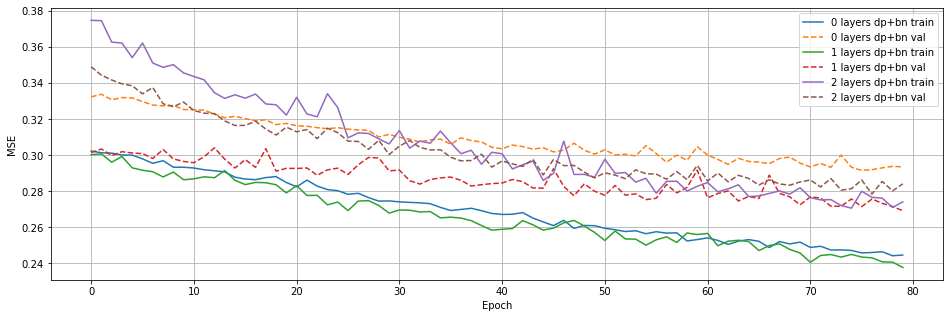

In [19]:
plt.figure(figsize = (16,5))
for i in range(3):
    plt.plot(train_mse[i][40:],'-',label = f'{i} layers dp+bn train')
    plt.plot(test_mse[i][40:],'--',label = f'{i} layers dp+bn val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid()
plt.show() 

Без нормализации и дропаута сеть сильно переобучается, и метрика на тесте хуже других примеров. При нормализации и регуляризации дропаутом после первого слоя результат не сильно лучше - сеть сильно переобучатся, но метрика чуть лучше.
При нормализации и дропауте после двух слоев обучение идет медленнее, но сеть не переобучается, а также видно, что у сети еще есть потенциал дообучиться. Есть возможность достигнуть лучшей метрики на тесте. Также еще одно наблюдение при применении дропаута - с ним обучение идет менее плавно, со скачками функции потерь, но зато сеть не переобучается.

Теперь попробуем разные оптимизаторы:

In [20]:
train_mse = []
test_mse = []
for i in range(3):
    net = FeedForward(8, 300, 2)
    if i == 0:
      optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    elif i == 1:
      optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, alpha=0.99)
    else:
      optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    train_losses, test_losses = learn_net(num_epochs)
    train_mse.append(train_losses)
    test_mse.append(test_losses)

Epoch [1/120]. Loss: 3.035. R2: -1.293. Test Loss: 3.897. Test R2: -0.589
Epoch [2/120]. Loss: 1.699. R2: -0.283. Test Loss: 2.436. Test R2: -0.132
Epoch [3/120]. Loss: 1.419. R2: -0.070. Test Loss: 1.317. Test R2: 0.020
Epoch [4/120]. Loss: 1.203. R2: 0.088. Test Loss: 1.054. Test R2: 0.094
Epoch [5/120]. Loss: 1.087. R2: 0.180. Test Loss: 0.974. Test R2: 0.184
Epoch [6/120]. Loss: 1.037. R2: 0.220. Test Loss: 0.934. Test R2: 0.299
Epoch [7/120]. Loss: 0.993. R2: 0.250. Test Loss: 0.898. Test R2: 0.264
Epoch [8/120]. Loss: 0.947. R2: 0.284. Test Loss: 0.858. Test R2: 0.282
Epoch [9/120]. Loss: 0.934. R2: 0.300. Test Loss: 0.824. Test R2: 0.236
Epoch [10/120]. Loss: 0.889. R2: 0.329. Test Loss: 0.797. Test R2: 0.349
Epoch [11/120]. Loss: 0.867. R2: 0.344. Test Loss: 0.770. Test R2: 0.457
Epoch [12/120]. Loss: 0.823. R2: 0.379. Test Loss: 0.738. Test R2: 0.394
Epoch [13/120]. Loss: 0.809. R2: 0.388. Test Loss: 0.705. Test R2: 0.411
Epoch [14/120]. Loss: 0.780. R2: 0.412. Test Loss: 0.68

Epoch [114/120]. Loss: 0.286. R2: 0.784. Test Loss: 0.286. Test R2: 0.781
Epoch [115/120]. Loss: 0.283. R2: 0.786. Test Loss: 0.286. Test R2: 0.785
Epoch [116/120]. Loss: 0.291. R2: 0.781. Test Loss: 0.285. Test R2: 0.761
Epoch [117/120]. Loss: 0.291. R2: 0.780. Test Loss: 0.284. Test R2: 0.784
Epoch [118/120]. Loss: 0.281. R2: 0.787. Test Loss: 0.295. Test R2: 0.749
Epoch [119/120]. Loss: 0.287. R2: 0.783. Test Loss: 0.284. Test R2: 0.806
Epoch [120/120]. Loss: 0.283. R2: 0.787. Test Loss: 0.289. Test R2: 0.792
Training is finished!
Epoch [1/120]. Loss: 2.175. R2: -0.633. Test Loss: 2.719. Test R2: 0.032
Epoch [2/120]. Loss: 1.099. R2: 0.169. Test Loss: 1.334. Test R2: 0.187
Epoch [3/120]. Loss: 0.978. R2: 0.263. Test Loss: 0.888. Test R2: 0.269
Epoch [4/120]. Loss: 0.896. R2: 0.322. Test Loss: 0.792. Test R2: 0.392
Epoch [5/120]. Loss: 0.840. R2: 0.365. Test Loss: 0.739. Test R2: 0.406
Epoch [6/120]. Loss: 0.802. R2: 0.395. Test Loss: 0.683. Test R2: 0.464
Epoch [7/120]. Loss: 0.757.

Epoch [106/120]. Loss: 0.291. R2: 0.781. Test Loss: 0.301. Test R2: 0.762
Epoch [107/120]. Loss: 0.272. R2: 0.795. Test Loss: 0.284. Test R2: 0.796
Epoch [108/120]. Loss: 0.274. R2: 0.793. Test Loss: 0.287. Test R2: 0.785
Epoch [109/120]. Loss: 0.275. R2: 0.792. Test Loss: 0.281. Test R2: 0.785
Epoch [110/120]. Loss: 0.275. R2: 0.793. Test Loss: 0.297. Test R2: 0.792
Epoch [111/120]. Loss: 0.278. R2: 0.790. Test Loss: 0.283. Test R2: 0.807
Epoch [112/120]. Loss: 0.274. R2: 0.792. Test Loss: 0.287. Test R2: 0.793
Epoch [113/120]. Loss: 0.278. R2: 0.790. Test Loss: 0.286. Test R2: 0.792
Epoch [114/120]. Loss: 0.269. R2: 0.797. Test Loss: 0.283. Test R2: 0.794
Epoch [115/120]. Loss: 0.281. R2: 0.787. Test Loss: 0.282. Test R2: 0.788
Epoch [116/120]. Loss: 0.270. R2: 0.796. Test Loss: 0.284. Test R2: 0.804
Epoch [117/120]. Loss: 0.275. R2: 0.792. Test Loss: 0.303. Test R2: 0.755
Epoch [118/120]. Loss: 0.270. R2: 0.796. Test Loss: 0.284. Test R2: 0.823
Epoch [119/120]. Loss: 0.274. R2: 0.79

Epoch [98/120]. Loss: 0.418. R2: 0.683. Test Loss: 0.360. Test R2: 0.663
Epoch [99/120]. Loss: 0.427. R2: 0.676. Test Loss: 0.366. Test R2: 0.655
Epoch [100/120]. Loss: 0.410. R2: 0.689. Test Loss: 0.362. Test R2: 0.692
Epoch [101/120]. Loss: 0.416. R2: 0.686. Test Loss: 0.362. Test R2: 0.709
Epoch [102/120]. Loss: 0.416. R2: 0.685. Test Loss: 0.360. Test R2: 0.666
Epoch [103/120]. Loss: 0.416. R2: 0.685. Test Loss: 0.360. Test R2: 0.674
Epoch [104/120]. Loss: 0.422. R2: 0.680. Test Loss: 0.361. Test R2: 0.636
Epoch [105/120]. Loss: 0.413. R2: 0.689. Test Loss: 0.358. Test R2: 0.693
Epoch [106/120]. Loss: 0.417. R2: 0.685. Test Loss: 0.361. Test R2: 0.692
Epoch [107/120]. Loss: 0.408. R2: 0.693. Test Loss: 0.359. Test R2: 0.672
Epoch [108/120]. Loss: 0.407. R2: 0.693. Test Loss: 0.355. Test R2: 0.691
Epoch [109/120]. Loss: 0.403. R2: 0.694. Test Loss: 0.356. Test R2: 0.703
Epoch [110/120]. Loss: 0.407. R2: 0.692. Test Loss: 0.356. Test R2: 0.662
Epoch [111/120]. Loss: 0.400. R2: 0.698.

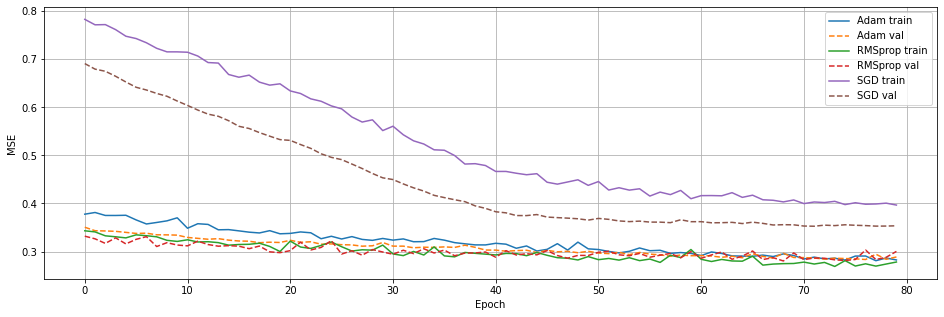

In [21]:
plt.figure(figsize = (16,5))
optims_label = ['Adam', 'RMSprop', 'SGD']
for i in range(3):
    plt.plot(train_mse[i][40:],'-',label = f'{optims_label[i]} train')
    plt.plot(test_mse[i][40:],'--',label = f'{optims_label[i]} val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid()
plt.show()

**SGD.** Обучение идет очень плавно, но явно не дообучается. Видимо, та самая седловая точка, или локальный минимум, из которого оптимизатор выпрыгнуть не смог.

**RMSprop.** Сходится быстрее всех, но уж очень напрягают сильные скачки функции потерь.

**Adam.** Показал себя лучше всех. Обучение довольно плавное, без скачков, сходится чуть медлееннее RMSprop, но зато сходится гарантированно.